In [1]:
import sys
sys.path.append('../')

from quantumsim import *
from pennylane import numpy as np
import matplotlib.pyplot as plt

import time
from pympler import asizeof

sz = np.array([[1,0],[0,-1]], dtype="float64")
si = np.array([[1,0],[0,1]], dtype="float64")
sx = np.array([[0,1],[1,0]], dtype="float64")
sy = np.array([[0,-1j],[1j,0]], dtype="complex64")

def terms(index, operator, qubits):
    k=0
    if k in index:
        if operator == "X":
            matriz = sx
        elif operator == "Z":
            matriz = sz
        elif operator == "Y":
            matriz = sy
    else:
        matriz = si
        
    k=1
    while k != qubits:
        if k in index:
            if operator == "X":
                matriz = np.kron(matriz, sx)
            elif operator == "Z":
                matriz = np.kron(matriz, sz)
            elif operator == "Y":
                matriz = np.kron(matriz, sy)
        else:
            matriz = np.kron(matriz, si)
        k=k+1
    return matriz

### Memoria

In [23]:
def pennylane_hamil(qubits, params):
    terms = []
    coeff = []

    matrix = np.zeros((qubits,qubits))
    for i in range(qubits-1):
        Xterm = ["I"]*qubits
        Yterm = ["I"]*qubits
        Zterm = ["I"]*qubits

        Xterm[i] = "X"; Xterm[i+1]= "X"
        Yterm[i] = "Y"; Yterm[i+1]= "Y"
        Zterm[i] = "Z"; Zterm[i+1]= "Z"

        terms.extend( [qml.pauli.string_to_pauli_word(list_to_string(Xterm)),
            qml.pauli.string_to_pauli_word(list_to_string(Yterm)),
            qml.pauli.string_to_pauli_word(list_to_string(Zterm))] )

        coeff.extend( [-params["exchange"][0], -params["exchange"][1], -params["exchange"][2]] )

    return asizeof.asizeof(terms) + asizeof.asizeof(coeff)

In [4]:
print("Representacion pennylane")
for i in range(1, 10):
    params = {
        "sites": i+1,
        "spin": 0.5, 
        "pattern": "open",
        "exchange": [1,1,1]
    }
    print( pennylane_hamil(i+1, params) )

print("Nuestra representacion")
for i in range(1, 10):
    params = {
        "sites": i+1,
        "spin": 0.5, 
        "pattern": "open",
        "exchange": [1,1,1]
    }
    system = vqe_spin(params)
    system.set_group_characteristics()
    print(asizeof.asizeof(system))

Representacion pennylane
10272
17488
23880
29360
36408
43328
50376
57272
64168
Nuestra representacion
2632
2920
3288
3768
4424
5192
6688
9208
13824


### XXX model open

In [53]:
exchanges = np.linspace(-1.5, 1.5, 51)
valores_xxx_open = []
valores_xxx_close = []
itera = 100
sites = 5

print("open")
for j in exchanges:
    params = {
        "sites": sites,
        "spin": 0.5, 
        "pattern": "open",
        "exchange": [j,j,j]
    }

    open_spin_chain = vqe_spin(params)
    open_spin_chain.set_group_characteristics()
    aux = []

    ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 0,
        "qubits": open_spin_chain.qubits,
        "pattern": "chain"
    }

    ansazt = he_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
        "maxiter": itera,
        "tol": 0.000001,
        "number": open_spin_chain.qubits*ansatz_params["repetitions"],
        "theta":["generic", 0.3]}

    open_spin_chain.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(open_spin_chain.cost_function)
    valores_xxx_open.append(energy1[-1])

print("close")
for j in exchanges:
    params = {
        "sites": sites,
        "spin": 0.5, 
        "pattern": "close",
        "exchange": [j,j,j]
    }

    open_spin_chain = vqe_spin(params)
    open_spin_chain.set_group_characteristics()
    aux = []

    ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 0,
        "qubits": open_spin_chain.qubits,
        "pattern": "ring"
    }
    ansazt = he_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
        "maxiter": itera,
        "tol": 0.000001,
        "number": open_spin_chain.qubits*ansatz_params["repetitions"],
        "theta":["generic", 0.3]}

    open_spin_chain.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(open_spin_chain.cost_function)
    valores_xxx_close.append(energy1[-1])

open
close


In [51]:
qubits = sites
xx_open=np.zeros((2**qubits, 2**qubits), dtype="float64")
yy_open=np.zeros((2**qubits, 2**qubits), dtype="complex64")
zz_open=np.zeros((2**qubits, 2**qubits), dtype="float64")
for i in range(qubits-1):
    xx_open += terms([i,i+1], "X", qubits)
    yy_open += terms([i,i+1], "Y", qubits)
    zz_open += terms([i,i+1], "Z", qubits)

xx_close = xx_open + terms([0,qubits-1], "X", qubits)
yy_close = yy_open + terms([0,qubits-1], "Y", qubits)
zz_close = zz_open + terms([0,qubits-1], "Z", qubits)

exacto_open = []
exacto_close = []
for j in exchanges:
    h =  -j*xx_open + -j*yy_open + -j*zz_open
    aux =  np.linalg.eigvals(h)
    exacto_open.append( np.sort(aux)[0] )

for j in exchanges:
    h =  -j*xx_close + -j*yy_close + -j*zz_close
    aux =  np.linalg.eigvals(h)
    exacto_close.append(np.sort(aux)[0])

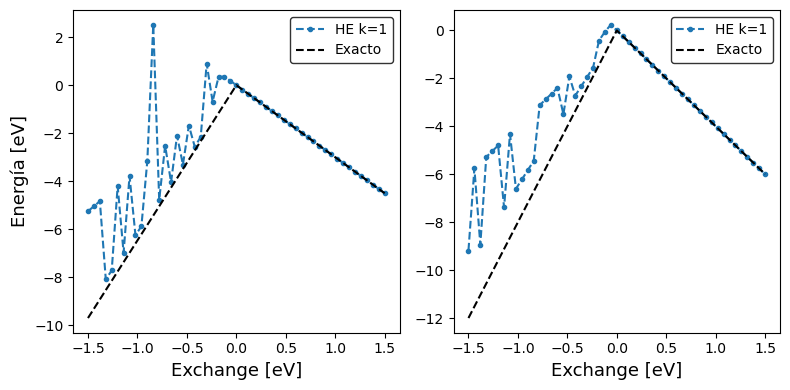

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Exchange [eV]", fontsize=13)
ax[1].set_xlabel("Exchange [eV]", fontsize=13)
ax[0].set_ylabel("Energía [eV]", fontsize=13)

ax[0].plot(exchanges, valores_xxx_open, marker='.', ls="dashed", label="HE k=1")
ax[0].plot(exchanges, exacto_open, color="black", ls="dashed", label="Exacto")

ax[1].plot(exchanges, valores_xxx_close, marker='.', ls="dashed", label="HE k=1")
ax[1].plot(exchanges, exacto_close, color="black", ls="dashed", label="Exacto")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
ax[1].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

In [38]:
exchanges = [-1, 1]
valores_xxx = []


for j in exchanges:
    params = {
        "sites": 8,
        "spin": 0.5, 
        "pattern": "close",
        "exchange": [j,j,j]
    }

    open_spin_chain = vqe_spin(params)
    open_spin_chain.set_group_characteristics()
    aux = []

    for k in range(3):
        ansatz_params = {
            "repetitions": k+1,
            "base": "default.qubit",
            "interface": "autograd",
            "electrons": 0,
            "qubits": open_spin_chain.qubits,
            "pattern": "chain"
        }

        differents_ansatz = []
        parameters = []

        ansazt = he_ansatz()
        ansazt.set_device( ansatz_params )
        ansazt.set_node( ansatz_params )
        ansazt.set_state( ansatz_params["electrons"] )

        minimizate_params = {
                "type": "SLSQP",
                "maxiter": 40,
                "tol": 0.000001,
                "number": open_spin_chain.qubits*ansatz_params["repetitions"],
                "theta":["generic", 0.3]}

        open_spin_chain.node = ansazt.node
        optimizer = gradiend_optimizer(minimizate_params)
        energy1, optimum = optimizer.VQE(open_spin_chain.cost_function)
        aux.append(energy1)
    valores_xxx.append(aux)

+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1


/Users/jmflorez/miniconda3/envs/quantum-computing/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


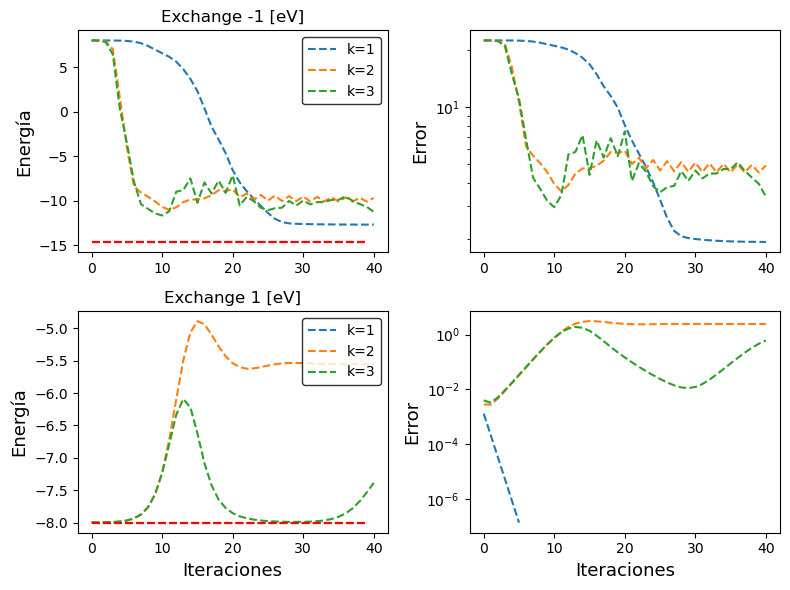

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(8,6),)
ax[1][0].set_xlabel("Iteraciones", fontsize=13)
ax[1][1].set_xlabel("Iteraciones", fontsize=13)
ax[0][0].set_ylabel("Energía", fontsize=13)
ax[1][0].set_ylabel("Energía", fontsize=13)

ax[0][1].set_ylabel("Error", fontsize=13)
ax[1][1].set_ylabel("Error", fontsize=13)

for i, val in enumerate(valores_xxx):
    ee = ocho_close(exchanges[i], exchanges[i], exchanges[i])

    for j,k in enumerate(val):
        ax[i][0].plot([m for m in range(len(k))], k, ls="dashed", label="k="+str(j+1))
        ax[i][0].plot([m for m in range( 40 ) ], [ee for _ in range(40)], "r", ls="dashed")
        ax[i][1].plot([m for m in range(len(k))], [np.abs(k[m] -ee) for m in range(len(k))], ls="dashed")
        ax[i][1].set_yscale("log")
    ax[i][0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
    ax[i][0].set_title("Exchange "+str(exchanges[i]) +" [eV]")

fig.tight_layout()
plt.show()

### XXZ model open

$j_x$ = 1 o -1

In [127]:
exchanges = [-2, -1, 0.0, 1, 2]
valores_xxx = []


for j in exchanges:
    params = {
        "sites": 10,
        "spin": 0.5, 
        "pattern": "close",
        "exchange": [1,1,j]
    }

    open_spin_chain = vqe_spin(params)
    open_spin_chain.set_group_characteristics()
    aux = []

    for k in range(3):
        ansatz_params = {
            "repetitions": k+1,
            "base": "default.qubit",
            "interface": "autograd",
            "electrons": 0,
            "qubits": open_spin_chain.qubits,
            "pattern": "ring"
        }

        differents_ansatz = []
        parameters = []

        ansazt = he_ansatz()
        ansazt.set_device( ansatz_params )
        ansazt.set_node( ansatz_params )
        ansazt.set_state( ansatz_params["electrons"] )

        minimizate_params = {
                "type": "SLSQP",
                "maxiter": 40,
                "tol": 0.000001,
                "number": open_spin_chain.qubits*ansatz_params["repetitions"],
                "theta":["generic", 0.3]}

        open_spin_chain.node = ansazt.node
        optimizer = gradiend_optimizer(minimizate_params)
        energy1, optimum = optimizer.VQE(open_spin_chain.cost_function)
        aux.append(energy1)
    valores_xxx.append(aux)

+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+

/Users/jmflorez/miniconda3/envs/quantum-computing/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


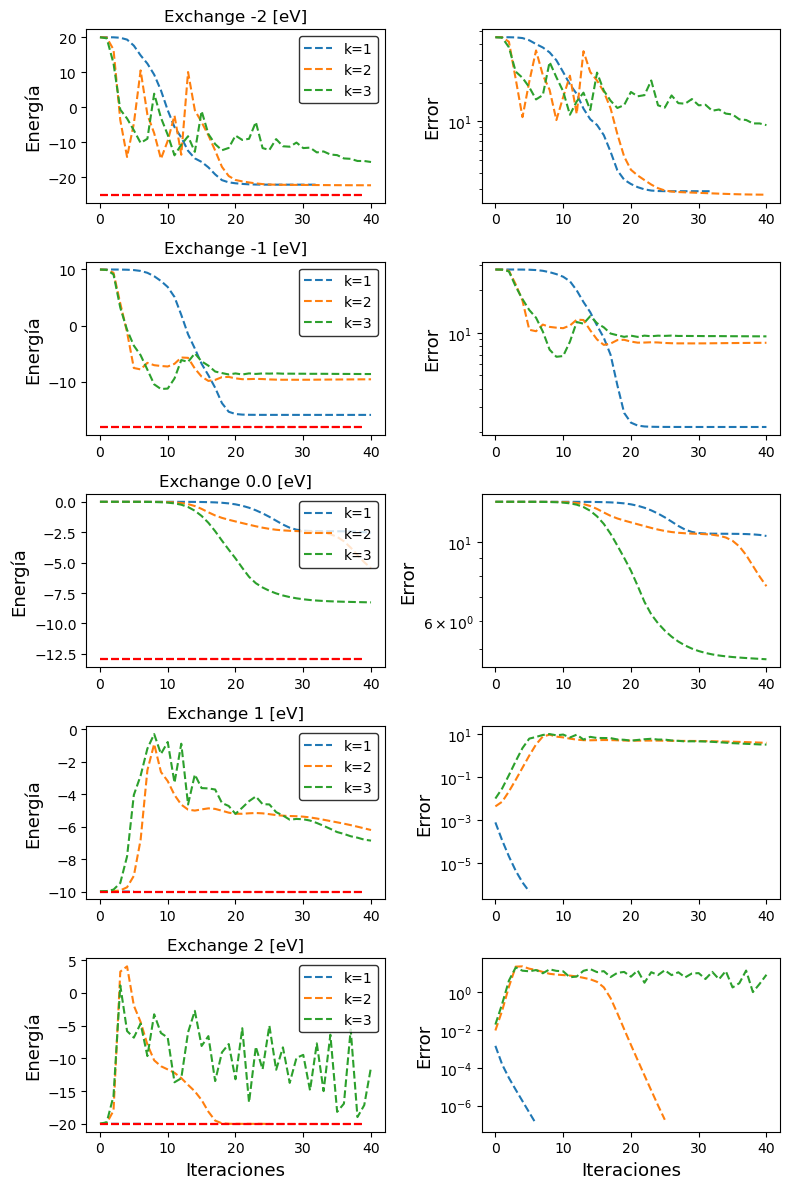

In [126]:
fig, ax = plt.subplots(5, 2, figsize=(8,12),)
ax[4][0].set_xlabel("Iteraciones", fontsize=13)
ax[4][1].set_xlabel("Iteraciones", fontsize=13)
ax[0][0].set_ylabel("Energía", fontsize=13)
ax[1][0].set_ylabel("Energía", fontsize=13)
ax[2][0].set_ylabel("Energía", fontsize=13)
ax[3][0].set_ylabel("Energía", fontsize=13)
ax[4][0].set_ylabel("Energía", fontsize=13)

ax[0][1].set_ylabel("Error", fontsize=13)
ax[1][1].set_ylabel("Error", fontsize=13)
ax[2][1].set_ylabel("Error", fontsize=13)
ax[3][1].set_ylabel("Error", fontsize=13)
ax[4][1].set_ylabel("Error", fontsize=13)

for i, val in enumerate(valores_xxx):
    ee = diez_close(1, 1, exchanges[i])

    for j,k in enumerate(val):
        ax[i][0].plot([m for m in range(len(k))], k, ls="dashed", label="k="+str(j+1))
        ax[i][0].plot([m for m in range( 40 ) ], [ee for _ in range(40)], "r", ls="dashed")
        ax[i][1].plot([m for m in range(len(k))], [np.abs(k[m] -ee) for m in range(len(k))], ls="dashed")
        ax[i][1].set_yscale("log")
    ax[i][0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
    ax[i][0].set_title("Exchange "+str(exchanges[i]) +" [eV]")

fig.tight_layout()
plt.show()

In [106]:
exchanges = np.linspace(-2, 2, 40)
valores_xxx_open = []
valores_xxx_close = []

for j in exchanges:
    params = {
        "sites": 10,
        "spin": 0.5, 
        "pattern": "close",
        "exchange": [-1,-1,j]
    }

    open_spin_chain = vqe_spin(params)
    open_spin_chain.set_group_characteristics()
    aux = []

    for k in range(1):
        ansatz_params = {
            "repetitions": k+1,
            "base": "default.qubit",
            "interface": "autograd",
            "electrons": 0,
            "qubits": open_spin_chain.qubits,
            "pattern": "ring"
        }

        differents_ansatz = []
        parameters = []

        ansazt = he_ansatz()
        ansazt.set_device( ansatz_params )
        ansazt.set_node( ansatz_params )
        ansazt.set_state( ansatz_params["electrons"] )

        minimizate_params = {
                "type": "SLSQP",
                "maxiter": 40,
                "tol": 0.000001,
                "number": open_spin_chain.qubits*ansatz_params["repetitions"],
                "theta":["generic", 0.3]}

        open_spin_chain.node = ansazt.node
        optimizer = gradiend_optimizer(minimizate_params)
        energy1, optimum = optimizer.VQE(open_spin_chain.cost_function)
        valores_xxx_open.append(energy1[-1])

for j in exchanges:
    params = {
        "sites": 10,
        "spin": 0.5, 
        "pattern": "close",
        "exchange": [1,1,j]
    }

    open_spin_chain = vqe_spin(params)
    open_spin_chain.set_group_characteristics()
    aux = []

    for k in range(1):
        ansatz_params = {
            "repetitions": k+1,
            "base": "default.qubit",
            "interface": "autograd",
            "electrons": 0,
            "qubits": open_spin_chain.qubits,
            "pattern": "ring"
        }

        differents_ansatz = []
        parameters = []

        ansazt = he_ansatz()
        ansazt.set_device( ansatz_params )
        ansazt.set_node( ansatz_params )
        ansazt.set_state( ansatz_params["electrons"] )

        minimizate_params = {
                "type": "SLSQP",
                "maxiter": 40,
                "tol": 0.000001,
                "number": open_spin_chain.qubits*ansatz_params["repetitions"],
                "theta":["generic", 0.3]}

        open_spin_chain.node = ansazt.node
        optimizer = gradiend_optimizer(minimizate_params)
        energy1, optimum = optimizer.VQE(open_spin_chain.cost_function)
        valores_xxx_close.append(energy1[-1])

+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+

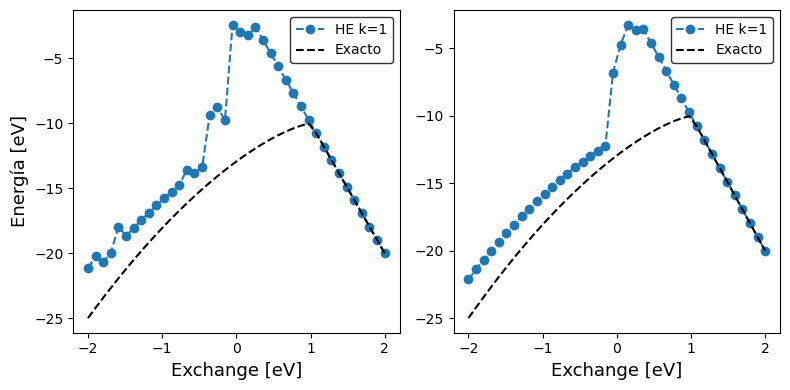

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Exchange [eV]", fontsize=13)
ax[1].set_xlabel("Exchange [eV]", fontsize=13)
ax[0].set_ylabel("Energía [eV]", fontsize=13)

ax[0].plot(np.linspace(-2, 2, 40), valores_xxx_open, marker='o', ls="dashed", label="HE k=1")
ax[0].plot(np.linspace(-2, 2, 40), [diez_close(-1, -1, j) for j in np.linspace(-2, 2, 40)], color="black", ls="dashed", label="Exacto")

ax[1].plot(np.linspace(-2, 2, 40), valores_xxx_close, marker='o', ls="dashed", label="HE k=1")
ax[1].plot(np.linspace(-2, 2, 40), [diez_close(1, 1, j) for j in np.linspace(-2, 2, 40)], color="black", ls="dashed", label="Exacto")

ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
ax[1].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

### Analisis de tiempos

In [4]:
j=1
params = {
    "sites": 14,
    "spin": 0.5, 
    "pattern": "open",
    "exchange": [j,j,j]
}

open_spin_chain = vqe_spin(params)
open_spin_chain.set_group_characteristics()
print(len(open_spin_chain.hamiltonian_object))
aux = []

ansatz_params = {
    "repetitions": 1,
    "base": "default.qubit",
    "interface": "autograd",
    "electrons": 0,
    "qubits": open_spin_chain.qubits,
    "pattern": "chain"
}


ansazt = he_ansatz()
ansazt.set_device( ansatz_params )
ansazt.set_node( ansatz_params )
ansazt.set_state( ansatz_params["electrons"] )

minimizate_params = {
    "type": "SLSQP",
    "maxiter": 40,
    "tol": 1e-6,
    "number": open_spin_chain.qubits*ansatz_params["repetitions"],
    "theta":["adam", 0.3]}

open_spin_chain.node = ansazt.node

tiempo = []
for i in range(10):
    optimizer = gradiend_optimizer(minimizate_params)

    inicio = time.time()
    energy1, optimum = optimizer.VQE(open_spin_chain.cost_function)
    final = time.time()

    tiempo.append(final-inicio)

3
-12.999596618439684
-12.469938347033269
-12.962494906941933
-12.875466227584514
-12.703027453164719
-12.782552298931527
-12.937776203897124
-12.987371374879515
-12.917589419269168
-12.856371456469867
-12.876915615531079
-12.947280251468221
-12.99169135305971
-12.9745627985432
-12.93395011856258
-12.92324037469514
-12.950531305321261
-12.983536867260208
-12.990836894195857
-12.974138649633655
-12.959454900496581
-12.96392560193556
-12.981330061241303
-12.9932387644516
-12.989864018850824
-12.979742739175595
-12.977286410711091
-12.98541007750538
-12.994204104786185
-12.994587047056333
-12.989065221707074
-12.986592433218094
-12.99051368684625
-12.995806526877963
-12.99667781004234
-12.993663723283765
-12.991941907791967
-12.994163925168936
-12.997469518658896
-12.997914648075577
-12.999536546891314
-12.470373517113853
-12.962433878067257
-12.877227924330812
-12.704843917865903
-12.781288290899312
-12.934909336435751
-12.98571388657714
-12.918702715144041
-12.859265286898601
-12.878691

KeyboardInterrupt: 

In [3]:
tiempo

[2.930802822113037,
 2.846886157989502,
 2.7930760383605957,
 2.7789759635925293,
 2.7729930877685547,
 2.7549350261688232,
 2.8211309909820557,
 2.760202169418335,
 2.764484167098999,
 2.7603111267089844]

In [2]:
sz = np.array([[1,0],[0,-1]])
si = np.array([[1,0],[0,1]])
sx = np.array([[0,1],[1,0]])
sy = np.array([[0,-1j],[1j,0]])

xx = np.kron( np.kron(np.kron(np.kron(sx,sx),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,sx),np.kron(sx,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(sx,sx)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,sx)),np.kron(sx,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(sx,sx)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,sx)), np.kron(np.kron(sx,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(sx,sx),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,sx),np.kron(sx,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(sx,np.kron(sx,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(sx,np.kron(sx,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(sx,np.kron(sx,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(sx,np.kron(sx,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(sx,sx)))))) ) 

yy = np.kron( np.kron(np.kron(np.kron(sy,sy),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,sy),np.kron(sy,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(sy,sy)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,sy)),np.kron(sy,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(sy,sy)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,sy)), np.kron(np.kron(sy,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(sy,sy),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,sy),np.kron(sy,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(sy,np.kron(sy,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(sy,np.kron(sy,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(sy,np.kron(sy,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(sy,np.kron(sy,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(sy,sy)))))) ) 

zz = np.kron( np.kron(np.kron(np.kron(sz,sz),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,sz),np.kron(sz,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(sz,sz)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,sz)),np.kron(sz,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(sz,sz)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,sz)), np.kron(np.kron(sz,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(sz,sz),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,sz),np.kron(sz,np.kron(si,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(sz,np.kron(sz,np.kron(si,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(sz,np.kron(sz,np.kron(si,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(sz,np.kron(sz,np.kron(si,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(sz,np.kron(sz,si)))))) ) +\
np.kron( np.kron(np.kron(np.kron(si,si),np.kron(si,si)),np.kron(si,si)), np.kron(np.kron(si,si),np.kron(si,np.kron(si,np.kron(si,np.kron(si,np.kron(sz,sz)))))) ) 

def diez(j1,j2,j3):
    h =  -j1*xx + -j2*yy + -j3*zz
    inicio = time.time()
    aux =  np.linalg.eigvals(h)
    final = time.time()    
    return final - inicio 


tiempo = []
for i in range(10):
    print(i+1)
    energy1 = diez(1,1,1)

    tiempo.append(energy1 )
    print(tiempo)

1
[1219.7731602191925]
2
[1219.7731602191925, 1268.2081480026245]
3
[1219.7731602191925, 1268.2081480026245, 1327.0220310688019]
4


In [39]:
for i in tiempo:
    print(f'{i:.12f}')

61.470633983612
51.289412021637
52.046790122986
52.781841278076
51.693025827408
51.198516130447
51.355216026306
50.384452104568
50.575860023499
51.863159179688
